# Part III- SupriseLib and Custom Recommender (Content Based) to recommend projects to Donors
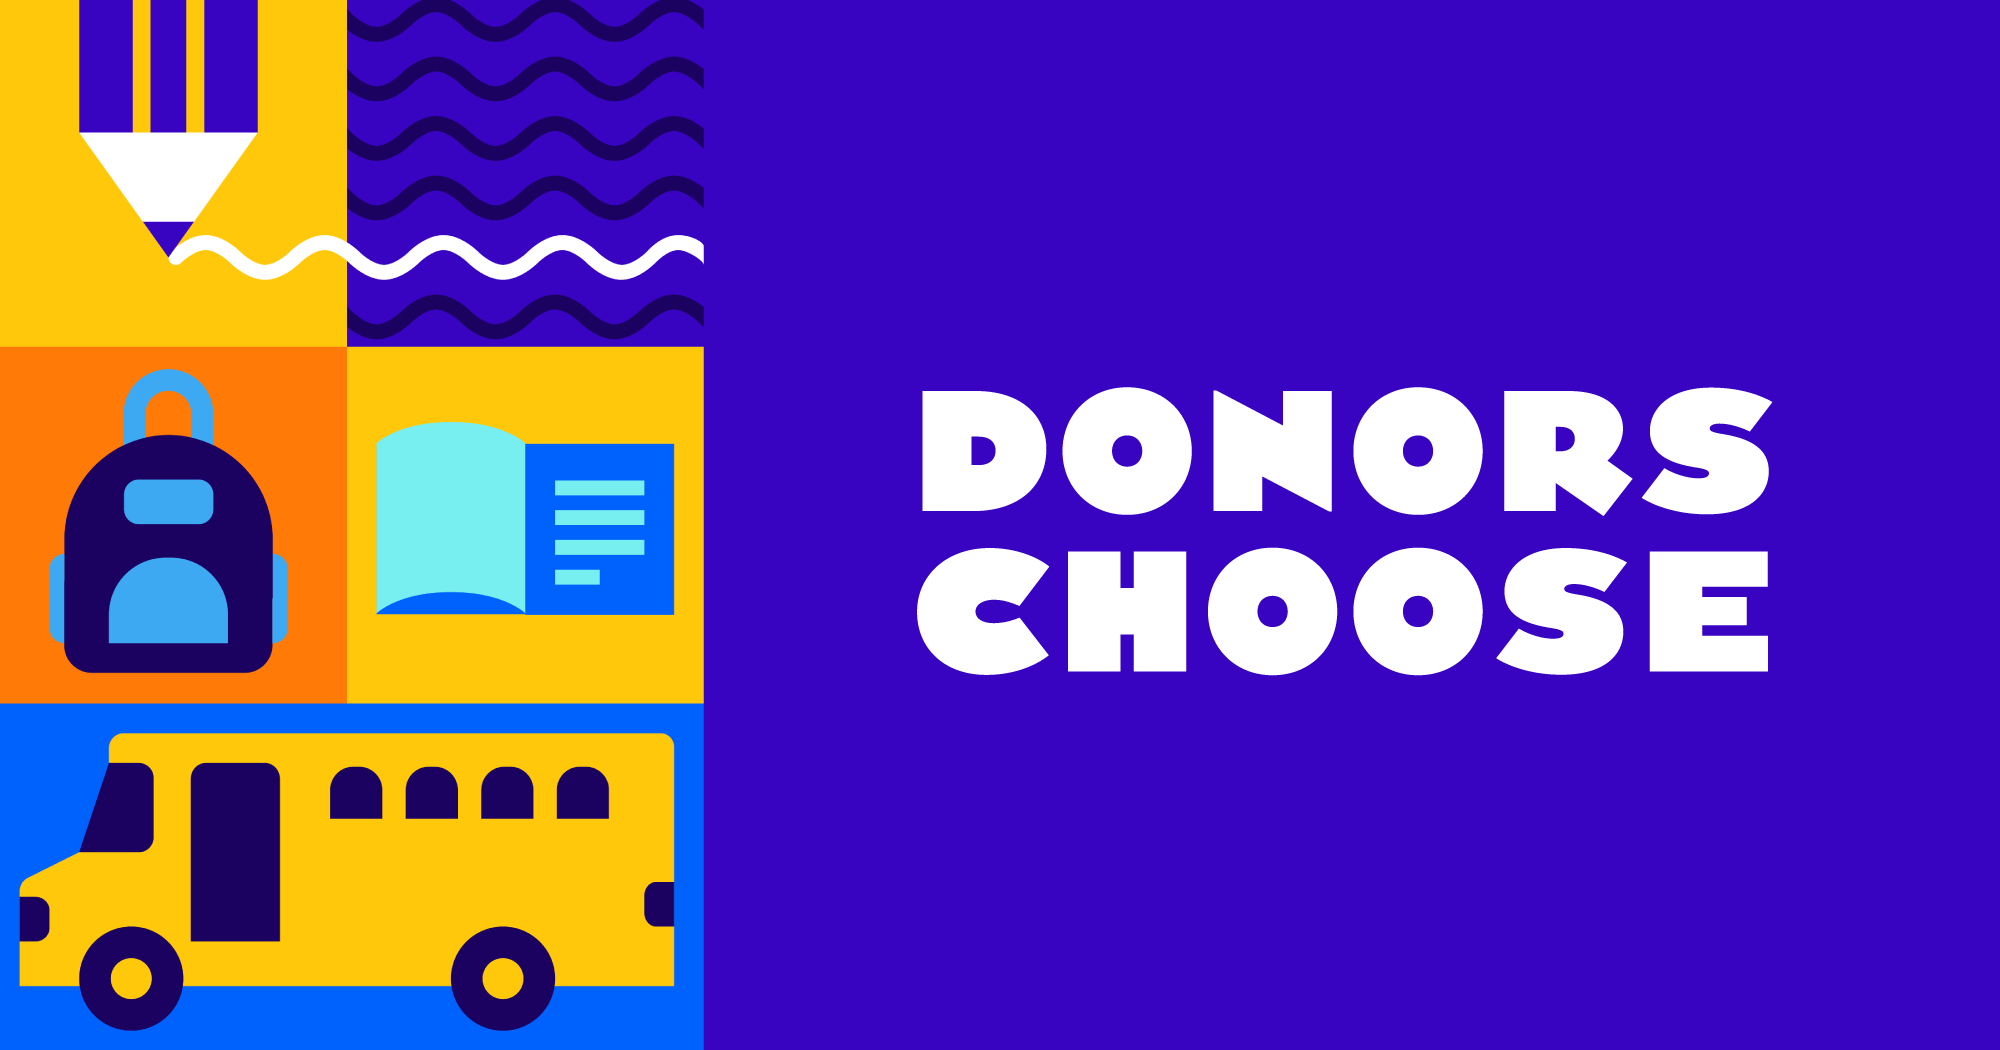
<p>Recommend projects that have similar categories and sub categories to the project the donor had previously donated to!</p>
<p>We measure similarity using <b> Cosine Similarity</b></p>
<li>Cosine (0) – 1 similar
<li>Cosine (90) – 0 not similar
<li>Cosine (45) – 0.7
<p> We use multi-dimensional cosine similarity to scale it to many dimensions (categories)</p>
    <p> <b> k-nearest-neighbors:</b>
<li>	Compute the similarity score between the project you want to predict and all the project the donor donated to
<li>	Select k projects with the highest similarity to the project we are making the prediction for.
<li>	Take weighted average of the similarity scores
</p>
 

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import math
import heapq
from tqdm import tqdm

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import LeaveOneOut
from surprise.model_selection import train_test_split
from surprise import KNNBaseline
from RecommenderMetricsDonorChoose import RecommenderMetrics

# If the prediction is impossible
from surprise import PredictionImpossible

from surprise import AlgoBase

<div class="alert alert-block alert-warning">  
    <p>We are using <b>Suprise</b> - a Python scikit library for recommender system.<p> We build a custom prediction model- Content based, using Suprise.</p>
    <p>The following <b>2 </b>cells are for reference of the dataset we are using!</p>
</div>

In [2]:
# For reference
projects_path = 'Projects_Oakland.csv'
projects_DF = pd.read_csv(projects_path) 
print(projects_DF.shape)
projects_DF.head()

(17431, 5)


,Project ID,Project Title,Project Subject Category Tree,Project Subject Subcategory Tree,Project Current Status
0,c04935c54c6923eb5a3ad4a4eb0b0f92,Helping the Band Purr: Journey for a Bass Clar...,Music & The Arts,Music,Expired
1,c493dd3d1d62f9d4ac818c00a4e5cbcc,Grab Those Greek Myths Round 2!,Literacy & Language,Literature & Writing,Fully Funded
2,7ea57b6fb70d189edb64132d5ec6f86e,Getting Graphic: Bridging The Language Gap Wit...,Literacy & Language,"ESL, Literacy",Fully Funded
3,c5e81eacaea132404ec851372f543ee8,Teach Me How To Wobble,Applied Learning,Other,Fully Funded
4,55f9a00e3c33cb133d90193e26412705,STEM Schools First CIF Boy's Volleyball Team N...,Health & Sports,"Health & Wellness, Team Sports",Fully Funded


In [3]:
# For reference
donations_path = 'Donations_Oakland.csv'
donations_DF = pd.read_csv(donations_path)
donations_DF.head()

,Donor ID,Project ID,Event Strength
0,0005e94def8dbd5e0ca7a01437536f9a,c04935c54c6923eb5a3ad4a4eb0b0f92,1
1,0008b9b73b5eaeb5f96cbd673eca324b,c493dd3d1d62f9d4ac818c00a4e5cbcc,1
2,0018044947d8f129fd6df4b9e1648bae,7ea57b6fb70d189edb64132d5ec6f86e,1
3,0018044947d8f129fd6df4b9e1648bae,c5e81eacaea132404ec851372f543ee8,1
4,001866acfc2ca9ef789a17190082517a,55f9a00e3c33cb133d90193e26412705,1


<div class="alert alert-block alert-warning">  
<li> In this particular dataset, we cannot determine whether the donor liked or disliked the project. We make the assumption that if a donor has donated to a particular project, he likes it.
<li>The Donors Choose dataset does not have explicit rating column. We determine the event strength using a different criteria (see notebook that does the data processing). The event strength calculated ranges from 0 to 100. But we need not worry about rating in Content Based.
</div>

In [4]:
def load_dataset():
    # Define file path
    projects_path = 'Projects_Oakland.csv'
    donations_path = 'Donations_Oakland.csv'
    
    # Read file into Dataframe
    projects_DF = pd.read_csv(projects_path)    
    donations_DF = pd.read_csv(donations_path)
    
    donations_DF['Project ID'] = donations_DF['Project ID'].astype(str)
    donations_DF['Donor ID'] = donations_DF['Donor ID'].astype(str)
    # Reader class is used to parse a file containing ratings
    # The structure is as follows
    # user ; item ; rating ; [timestamp]
    # Dataset.load_from_file - loads a custom file
    reader = Reader(rating_scale=(1, 100))
    donations_dataset = Dataset.load_from_df( donations_DF[['Donor ID','Project ID','Event Strength']], reader=reader)
    
    return donations_dataset

<div class="alert alert-block alert-warning">  
    <li> <b>Popularity rank</b> - Projects that have the most donations
    <li> We need it to measure <b>Novelty</b>
</div>

In [5]:
def get_popularity_rank():
    popular_DF = pd.DataFrame(donations_DF['Project ID'].value_counts())
    popular_DF.columns = ['count']
    popular_DF.sort_values('count',ascending = False)
    rank = [x for x in range(len(popular_DF))]
    popular_DF['rank'] = rank
    popular_DF.drop('count',axis = 1,inplace = True)
    return popular_DF.to_dict('dict')['rank']
#get_popularity_rank()

<div class="alert alert-block alert-warning">  
    <li> <b>Anti Test Set</b> - Excludes donor, project pairs that have already been donated to by user
    <li> Needed for testing when the algorithm is trained on the full dataset
</div>

In [6]:
def anti_test_set(test_subject,train_set):
    anti_test_set = []
    avg_rating = train_set.global_mean
    u = train_set.to_inner_uid(str(test_subject))
    #print(u)
    
    # j is item inner id
    # user_items is a list of inner item ids that test subject u rated
    user_items = set([j for (j, _) in train_set.ur[u]])
    
    # anti-test set - (test subject, item that is not already rated by test subject, global mean)
    for i in train_set.all_items():
        if i not in user_items:
            anti_test_set.append((train_set.to_raw_uid(u),train_set.to_raw_iid(i),avg_rating))
            
    return anti_test_set

<div class="alert alert-block alert-warning">  
    <li> We create 2 dictionaries to access the name and status of the project in Constant time
</div>

In [7]:
def get_project_id_name():
    return projects_DF.set_index('Project ID').to_dict('dict')['Project Title']

In [8]:
def get_project_id_status():
    return projects_DF.set_index('Project ID').to_dict('dict')['Project Current Status']

In [9]:
cat_max_id = 0
project_cat = defaultdict(list)
cat_id_dict = defaultdict(int)

def extract_categories(cols):
    global cat_max_id
    cat_list = []
    categories = cols[1].split(',')
    for cat in categories:
        cat = cat.strip()
        if cat not in cat_id_dict:
            cat_id_dict[cat] = cat_max_id
            cat_max_id+=1
        cat_list.append(cat_id_dict[cat])
    project_cat[cols[0]] = cat_list 

In [10]:
def get_categories():
    projects_DF[['Project ID','Project Subject Category Tree']].apply(extract_categories, axis = 1)
    
    # Convert integer-encoded genre lists to bitfields that we can treat as vectors
    cat_no = len(cat_id_dict)
    for (project_id, cat_id_list) in project_cat.items():
        bitfield = [0] * cat_max_id
        for cat_id in cat_id_list:
            bitfield[cat_id] = 1
        project_cat[project_id] = bitfield 
    return project_cat

    
#get_categories()

In [11]:
sub_cat_max_id = 0
project_sub_cat = defaultdict(list)
sub_cat_id_dict = defaultdict(int)

def extract_sub_categories(cols):
    global sub_cat_max_id
    sub_cat_list = []
    sub_categories = cols[1].split(',')
    for sub_cat in sub_categories:
        sub_cat = sub_cat.strip()
        if sub_cat not in sub_cat_id_dict:
            sub_cat_id_dict[sub_cat] = sub_cat_max_id
            sub_cat_max_id+=1
        sub_cat_list.append(sub_cat_id_dict[sub_cat])
    project_sub_cat[cols[0]] = sub_cat_list 

In [12]:
def get_sub_categories():
    projects_DF[['Project ID','Project Subject Subcategory Tree']].apply(extract_sub_categories, axis = 1)
    
    # Convert integer-encoded genre lists to bitfields that we can treat as vectors
    sub_cat_no = len(sub_cat_id_dict)
    for (project_id, sub_cat_id_list) in project_sub_cat.items():
        bitfield = [0] * sub_cat_max_id
        for sub_cat_id in sub_cat_id_list:
            bitfield[sub_cat_id] = 1
        project_sub_cat[project_id] = bitfield 
    return project_sub_cat
    
#get_sub_categories()

<div class="alert alert-block alert-warning">  
    <li> This is the heart of the algorithm
    <li> The fit function can be used to perform operations on the entire train set
    <li> The estimate function is used to calculate the prediction for a given user and item
</div>

In [13]:
class Content_Based_KNN(AlgoBase):

    def __init__(self, k = 40, sim_options = {}):
        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k = k
        
    # Write logic that can be calculated independent of the user or item in questions
    def fit(self, trainset):
        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        categories = get_categories()
        sub_categories = get_sub_categories()
        
        print("Computing content-based similarity matrix...")
        
        # compute similarity matrix 2x2 | item x item
        self.similarities = np.zeros((self.trainset.n_items, self.trainset.n_items))
        
        # calculate pairwise similarity for all existing movies
        for project_a in tqdm(range(self.trainset.n_items)):
        #for project_a in tqdm(range(100)):
           # if (movie_a% 100 == 0):
                # print(movie_a, " of ", self.trainset.n_items)
            for project_b in range(project_a+1,self.trainset.n_items):
                project_a_id = self.trainset.to_raw_iid(project_a)
                project_b_id = self.trainset.to_raw_iid(project_b)
                category_similarity = self.compute_category_similarity(project_a_id, project_b_id, categories)
                sub_category_similarity = self.compute_category_similarity(project_a_id, project_b_id, sub_categories)
                self.similarities[project_a, project_b] =  category_similarity * sub_category_similarity
                self.similarities[project_b, project_a] = self.similarities[project_a, project_b]
                
        print("...done.")
        return self
    
    def compute_category_similarity(self, project1, project2, categories):
        # Cosine Similarity
        categories1 = categories[project1]
        categories2 = categories[project2]
        sumxx, sumxy, sumyy = 0, 0, 0
        for i in range(len(categories1)):
            x = categories1[i]
            y = categories2[i]
            sumxx += x * x
            sumyy += y * y
            sumxy += x * y
        return sumxy/math.sqrt(sumxx*sumyy)
        
    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('Donor and/or project is unkown.')
        # a.
        # Get all projects the donor has donated to
        neighbors = []
        for rating in self.trainset.ur[u]:
            # Fetch similarity between predictant project and projects user donated to
            project_similarity = self.similarities[i,rating[0]]
            # Append similarity score and rating
            neighbors.append((project_similarity, rating[1]))
        
        # b.
        # Extract the top-K most-similar ratings
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])

        
        # c.
        # Compute average sim score of K neighbors weighted by user ratings
        sim_total = weighted_sum = 0
        for (sim_score, rating) in k_neighbors:
            if (sim_score > 0):
                sim_total += sim_score
                weighted_sum += sim_score * rating
            
        if (sim_total == 0):
            raise PredictionImpossible('No neighbors')

        predicted_rating = weighted_sum / sim_total

        return predicted_rating

In [14]:
print("Loading Oaklander donations dataset...")
data = load_dataset() 
project_id_name_dict = get_project_id_name()
project_id_status_dict = get_project_id_status()
print("Done...")

Loading Oaklander donations dataset...
Done...


In [15]:
test_subject = '748989120f97e99c442d59d876584424'
donations_of_user = pd.DataFrame(donations_DF[donations_DF['Donor ID'] == test_subject]['Project ID'].value_counts())
donations_of_user.reset_index(inplace = True)
donations_of_user.columns = [['Project ID','Count']]
print('Donor',test_subject, 'has previously donated to..... \n \n')
for i in range(len(donations_of_user)):
    print(project_id_name_dict[donations_of_user.loc[i][0]],'-',donations_of_user.loc[i][1])

Donor 748989120f97e99c442d59d876584424 has previously donated to..... 
 

Spectacular Series for My Library! Chevron Fuel Your School - 2
Feeding on my Reading - 2
Let Me Take A Look, At This Book 2 - 2
A Listening Center For Little Readers - 1
Buff Up My Literature Circles with Contemporary Books - 1
"The Road" Takes Us To Places We Don't Expect - 1
Computer Literacy 3 - 1
Archimedes Needs a Lever Up! - 1
Help Make Our Students Bookworms and Authors! - 1
Fantastic Furniture Woodworking Supplies - 1
Samurai and Superheroes: Graphic Novels to Motivate Readers - 1
I Love To Read Non-Fiction Books! - 1
Book Club For Advanced Readers - 1
Eliminate Noise Pollution During Learning!  - 1
Writing to Discover: Exploring Science Through Journaling - 1
Holidays=Dias Festivos - 1
Discovering Shapes 4 - 1
Desks and Chairs Needed for Our Classroom - 1
Non-Fiction Books for Common Core Ready Students - 1
The Need to Read - 1
Algebra, Yes We Can - 1
SAT  and ACT practice books - 1
Engaging Science Cen

<div class="alert alert-block alert-warning">  
    <li>We are all set! Let's try running our content based recommender system!
</div>

In [17]:
algo = Content_Based_KNN()
full_train_set = data.build_full_trainset()
anti_test_set_for_user  = anti_test_set(test_subject, full_train_set)

algo.fit(full_train_set)
predictions = algo.test(anti_test_set_for_user)

  0%|          | 1/9576 [00:00<27:20,  5.84it/s]

Computing content-based similarity matrix...


100%|██████████| 9576/9576 [06:58<00:00, 22.86it/s] 


...done.


In [18]:
recommendations = []
print ("\nWe recommend:\n")
for donor_id, project_id, avg_rating, estimated_rating, _ in predictions:
    if project_id_status_dict[project_id] == 'Live':
        recommendations.append((project_id, estimated_rating))

recommendations.sort(key=lambda x: x[1], reverse=True)

for ratings in recommendations[:10]:
    #print(ratings[0])
    print(project_id_name_dict[ratings[0]])


We recommend:

We Need A Few More Computers...
Learning Can Be Easy and  Fun
 Makerspace! Preschoolers as Designers, Scientists, Architects and Engineers
We Need Chairs!!!
Microphones for Motivated Musicians
Building Engineers
iPad for Testing Prep
Footloose and Fancy-Free Fifth Graders Looking For Fidget-Freeing Seating
Tech Takeover
The Furniture Makes the Classroom
